<h1><center><font size="6">iWildCam 2019 EDA</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/0/01/Fauna.jpg" width="800"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

## Competition

Biologists all over the world use camera traps to monitor biodiversity and population density of animal species. They have recently been making strides towards automating the species classification challenge in camera traps, but as they try to expand the scope of these models from specific regions where they have collected training data to nearby areas we are faced with an interesting probem: how do you classify a species in a new region that you may not have seen in previous training data?

## Data

In order to tackle this problem, the competition organizers have prepared a challenge where the training data and test data are from different regions, namely The American Southwest and the American Northwest. The species seen in each region overlap, but are not identical, and the challenge is to classify the test species correctly.  

## Kernel

In this Kernel we perform EDA on the data and prepare for creation of a predictive model.

# <a id='2'>Prepare for data analysis</a>  


## Load packages

In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Load data   

Let's check what data files are available.

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/iwildcam/"
else:
    PATH="../input/"
os.listdir(PATH)

['sample_submission.csv',
 'test_images',
 'train_images',
 'test.csv',
 'train.csv']

In [3]:
%%time
train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(PATH, 'test.csv'))

CPU times: user 1.33 s, sys: 220 ms, total: 1.55 s
Wall time: 1.56 s


Let's check the files.

In [4]:
train_df.head()

category_id        date_captured   ...   width  height
0           19  2011-05-13 23:43:18   ...    1024     747
1           19  2012-03-17 03:48:44   ...    1024     747
2            0  2014-05-11 11:56:46   ...    1024     747
3            0  2013-10-06 02:00:00   ...    1024     747
4            0  2011-07-12 13:11:16   ...    1024     747

[5 rows x 11 columns]

In [5]:
test_df.head()

date_captured  ...   height
0  2016-01-03 11:30:56  ...      726
1  2016-01-03 11:30:57  ...      726
2  2016-01-03 11:30:58  ...      726
3  2016-01-03 11:30:59  ...      726
4  2016-01-03 11:31:00  ...      726

[5 rows x 10 columns]

In [6]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (196299, 11) (153730, 10)


# <a id='3'>Data exploration</a>  

Let's define the classes:

In [7]:
classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal', \
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote', \
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',\
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}

In [8]:
train_df['classes_wild'] = train_df['category_id'].apply(lambda cw: classes_wild[cw])

We check again train:

In [9]:
train_df.head()

category_id        date_captured      ...      height  classes_wild
0           19  2011-05-13 23:43:18      ...         747       opossum
1           19  2012-03-17 03:48:44      ...         747       opossum
2            0  2014-05-11 11:56:46      ...         747         empty
3            0  2013-10-06 02:00:00      ...         747         empty
4            0  2011-07-12 13:11:16      ...         747         empty

[5 rows x 12 columns]

## Check images  
Let's check how many images are in train and test images folders.

In [10]:
train_image_files = list(os.listdir(os.path.join(PATH,'train_images')))
test_image_files = list(os.listdir(os.path.join(PATH,'test_images')))
                         
print("Number of image files: train:{} test:{}".format(len(train_image_files), len(test_image_files)))

Number of image files: train:196086 test:153730


We can observe that the number of images in train folder is smaller that the number of rows in train dataset while the number of images in test folder is equal with the number of rows in test dataset.

Let's check if every row in train and test have a corresponding image in the images folders.

In [11]:
%%time
train_file_names = list(train_df['file_name'])
print("Matching train image names: {}".format(len(set(train_file_names).intersection(train_image_files))))

Matching train image names: 196086
CPU times: user 144 ms, sys: 20 ms, total: 164 ms
Wall time: 162 ms


In [12]:
%%time
test_file_names = list(test_df['file_name'])
print("Matching test image names: {}".format(len(set(test_file_names).intersection(test_image_files))))

Matching test image names: 153730
CPU times: user 92 ms, sys: 4 ms, total: 96 ms
Wall time: 93.3 ms


## Clases of images

Let's check the classes of images in train_df.

In [13]:
print("There are {} classes of images".format(train_df.classes_wild.nunique()))
pd.DataFrame(train_df.classes_wild.value_counts()).transpose()

There are 14 classes of images


empty  opossum      ...         fox  mountain_lion
classes_wild  131457    14106      ...        1093             33

[1 rows x 14 columns]

In [14]:
def plot_classes(feature, fs=8, show_percents=True, color_palette='Set3'):
    f, ax = plt.subplots(1,1, figsize=(2*fs,4))
    total = float(len(train_df))
    g = sns.countplot(train_df[feature], order = train_df[feature].value_counts().index, palette=color_palette)
    g.set_title("Number and percentage of labels for each class of {}".format(feature))
    if(show_percents):
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(100*height/total),
                    ha="center") 
    plt.show()    

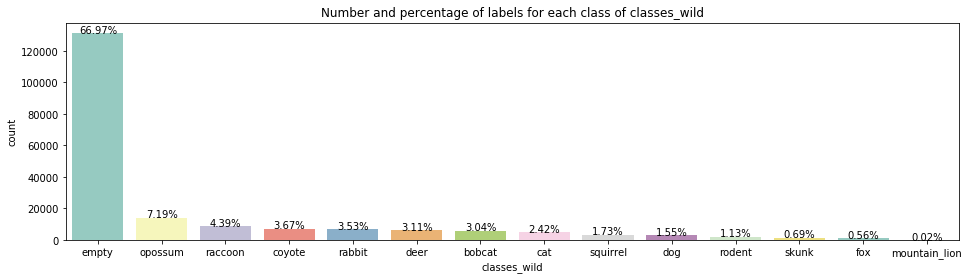

In [15]:
plot_classes('classes_wild')

Most of the images are of classe `empty`, followed by `opossum`, `racoon`, `coyote` and `rabbit`.

## Number of sequences frames

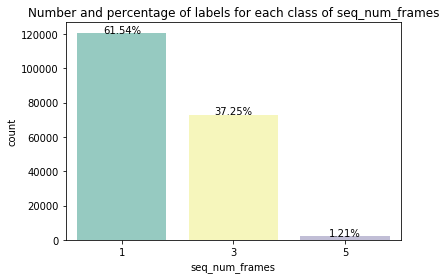

In [16]:
plot_classes('seq_num_frames', fs=3)

Majority of sequence number frames are 1 (61%), followed by 3 (37%), the rest (1.2%) having 5.

## Locations distribution

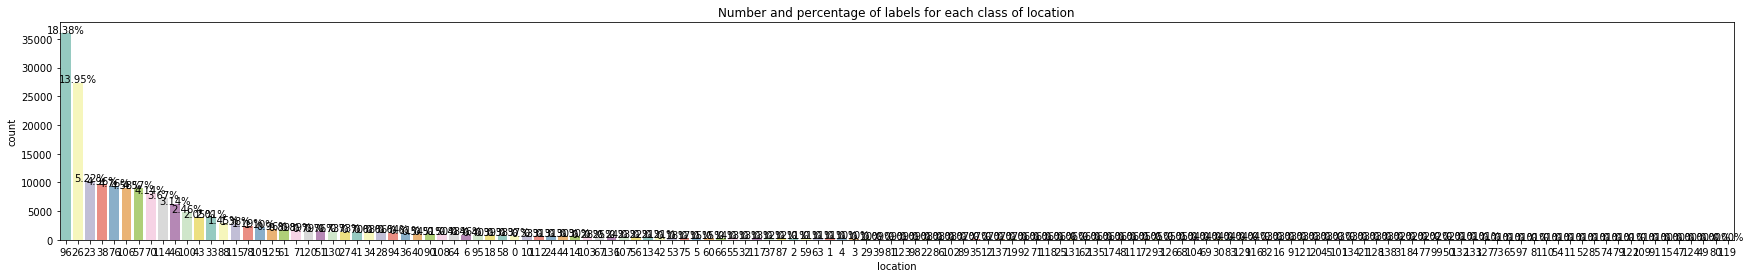

In [17]:
plot_classes('location', fs=15)

Majority of images are from location 96 (18.38%) and 26 (13.95%).

## Locations and classes

Let's show now the locations and classes.

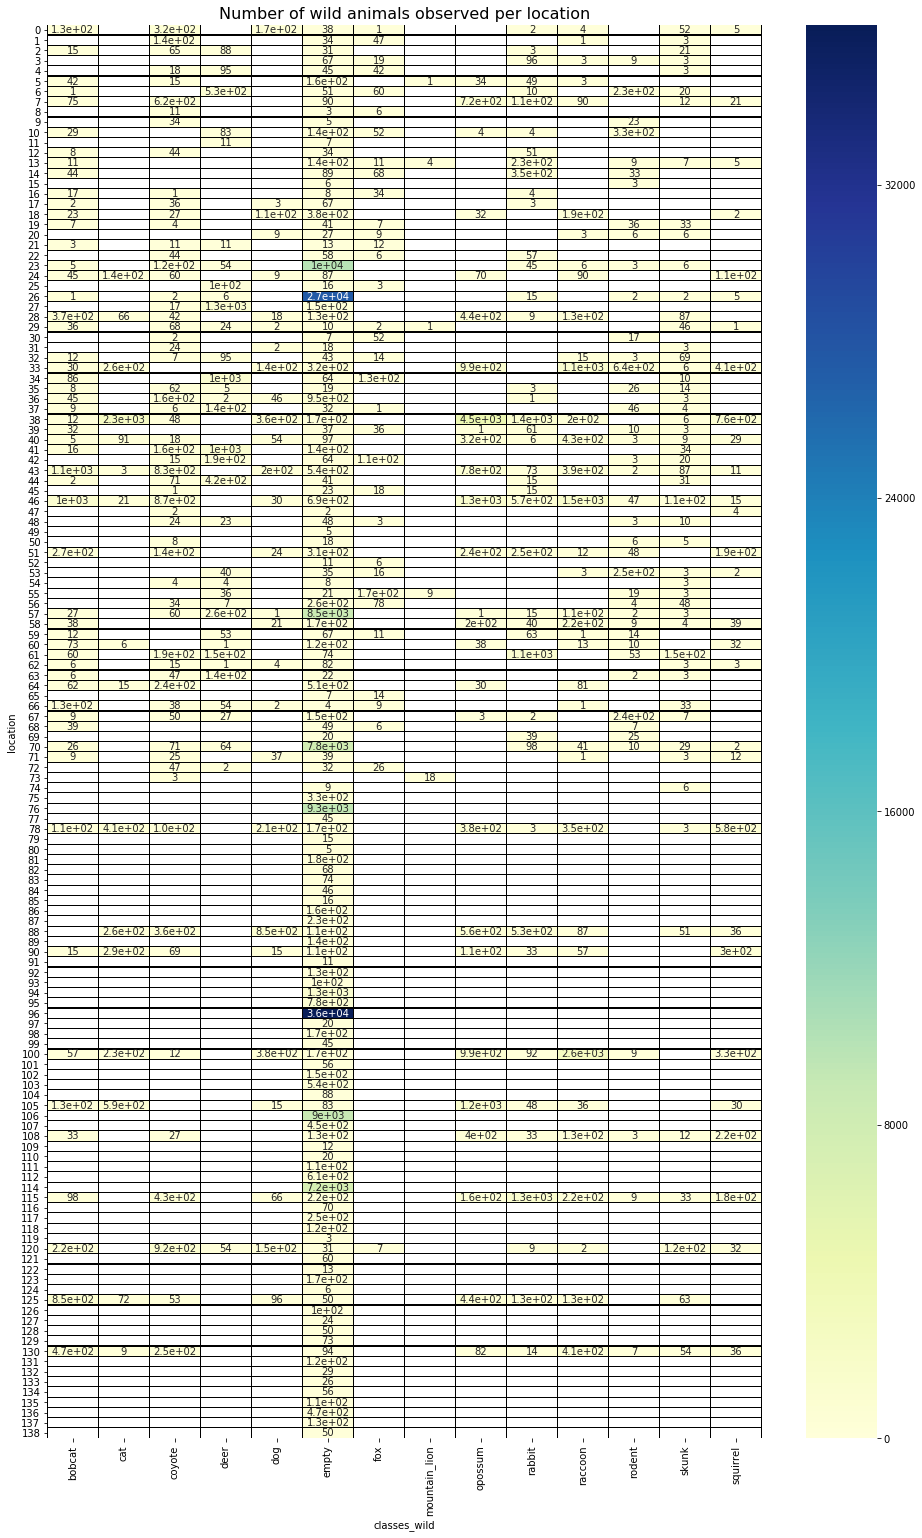

In [18]:
fig, ax = plt.subplots(1,1,figsize=(16,26))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'location'])['seq_id'].count().reset_index())
m = t.pivot(index='location', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per location', size=16)
plt.show()

Majority of records are actually from location 96 and without specifying the wild animal class (`empty`). Also, location 26 (the next one as frequence) is as well for `empty` class. Let's see what we get if we just remove the entries with `empty`.


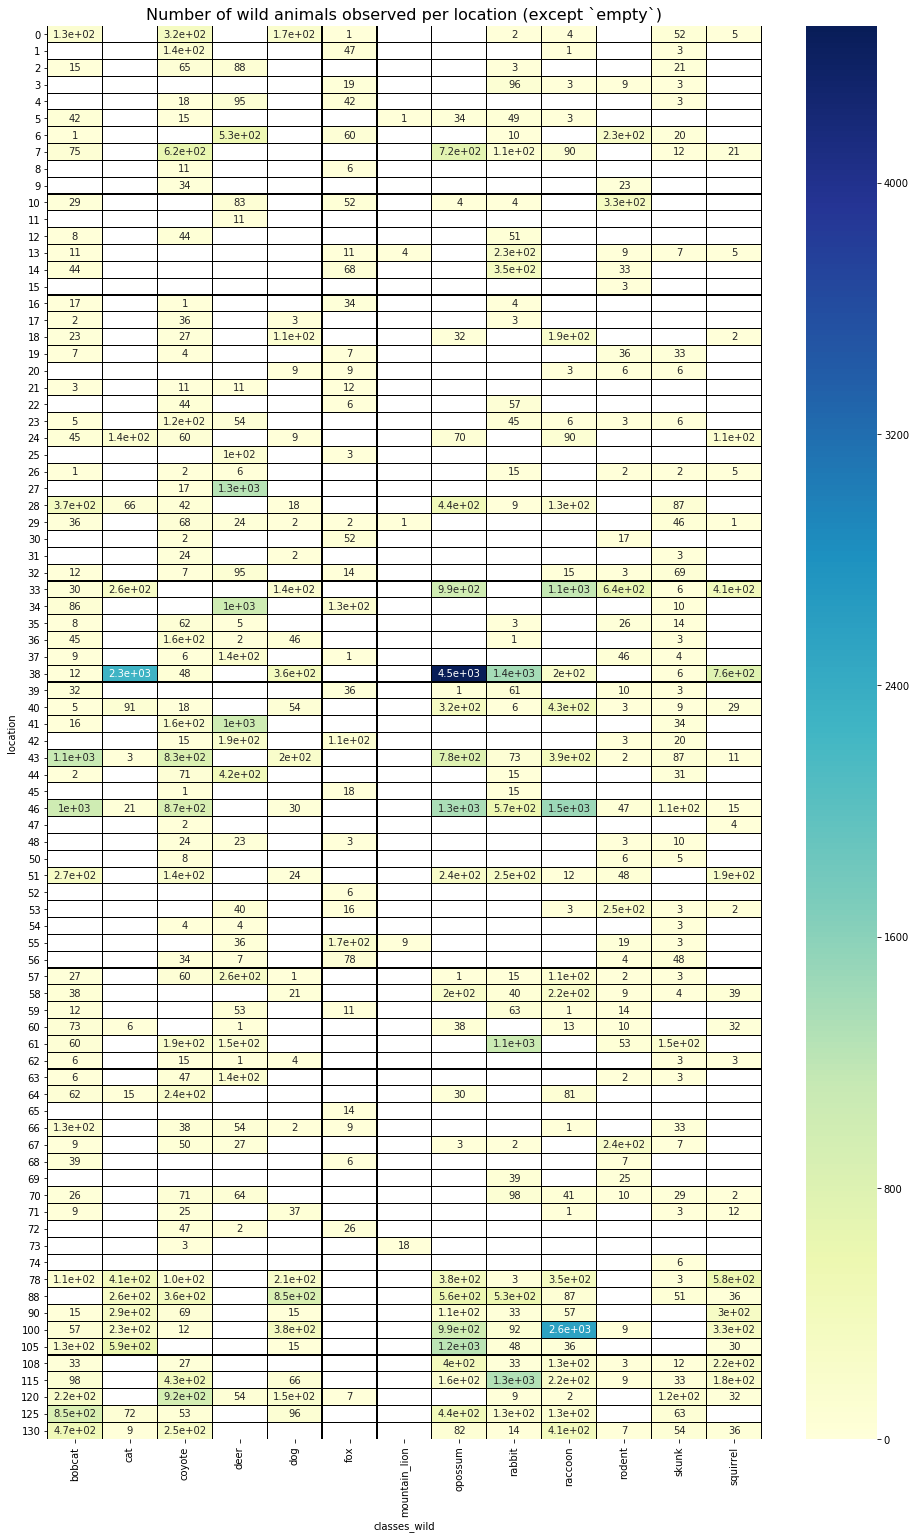

31166

In [19]:
fig, ax = plt.subplots(1,1,figsize=(16,26))
tmp = train_df[train_df['classes_wild'] != 'empty']
t = pd.DataFrame(tmp.groupby(['classes_wild', 'location'])['seq_id'].count().reset_index())
m = t.pivot(index='location', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per location (except `empty`)', size=16)
plt.show()
del t, tmp, m
gc.collect()

## Rights holder

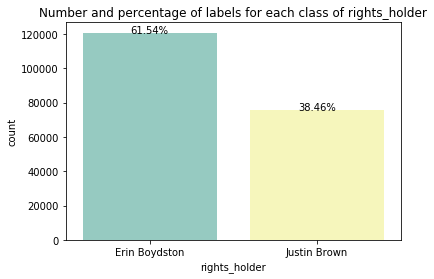

In [20]:
plot_classes('rights_holder', fs=3)

Only two rights holder are registered in `train_df` data.  

Let's check the rights holder and type of images taken by each.

## Rights holder and wild animals class


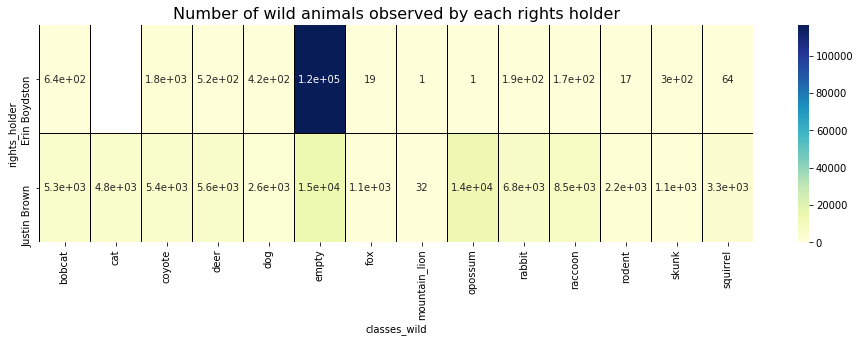

In [21]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'rights_holder'])['seq_id'].count().reset_index())
m = t.pivot(index='rights_holder', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed by each rights holder', size=16)
plt.show()

We remove the `empty` class to see better the other classes.

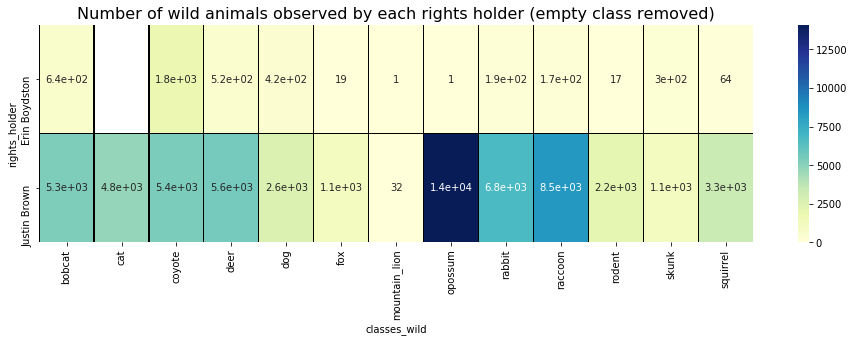

In [22]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
t = pd.DataFrame(train_df[~(train_df.classes_wild == 'empty')].groupby(['classes_wild', 'rights_holder'])['seq_id'].count().reset_index())
m = t.pivot(index='rights_holder', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed by each rights holder (empty class removed)', size=16)
plt.show()

## Extract date and time information

In [23]:
try:
    train_df['date_time'] = pd.to_datetime(train_df['date_captured'], errors='coerce')
    train_df["year"] = train_df['date_time'].dt.year
    train_df["month"] = train_df['date_time'].dt.month
    train_df["day"] = train_df['date_time'].dt.day
    train_df["hour"] = train_df['date_time'].dt.hour
    train_df["minute"] = train_df['date_time'].dt.minute
except Exception as ex:
    print("Exception:".format(ex))
    

Let's check again the data.

In [24]:
train_df.head()

category_id        date_captured   ...    hour  minute
0           19  2011-05-13 23:43:18   ...    23.0    43.0
1           19  2012-03-17 03:48:44   ...     3.0    48.0
2            0  2014-05-11 11:56:46   ...    11.0    56.0
3            0  2013-10-06 02:00:00   ...     2.0     0.0
4            0  2011-07-12 13:11:16   ...    13.0    11.0

[5 rows x 18 columns]

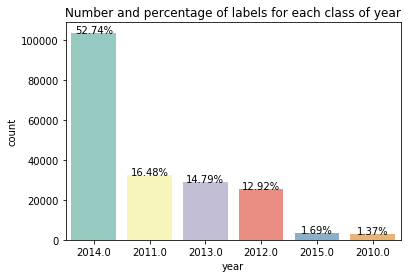

In [25]:
plot_classes('year', fs=3)

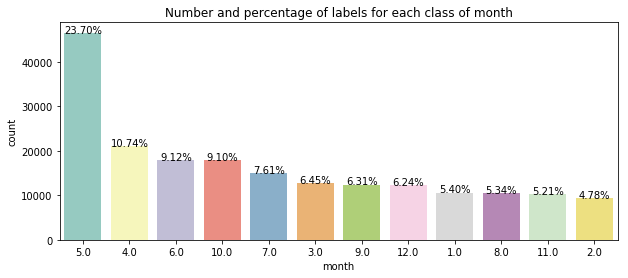

In [26]:
plot_classes('month', fs=5)

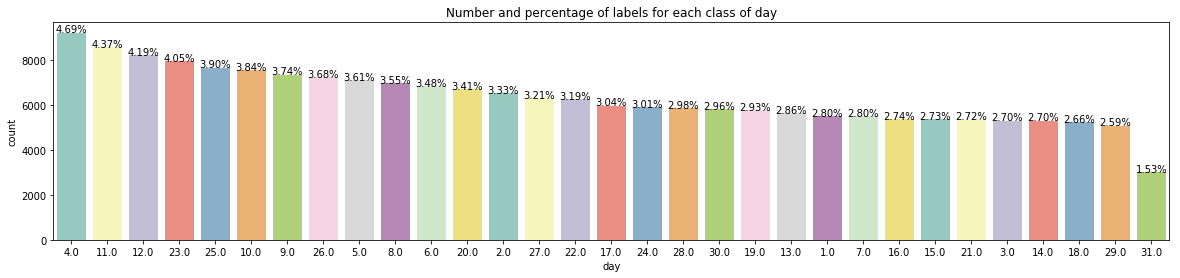

In [27]:
plot_classes('day', fs=10)

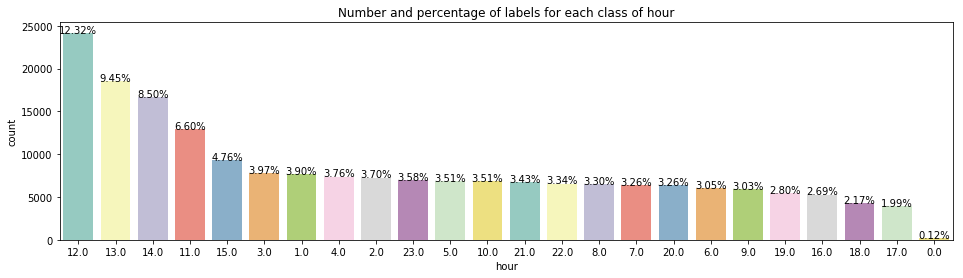

In [28]:
plot_classes('hour', fs=8)

## Classes and hours  

Let's show the number of wild animals observed at different hours.

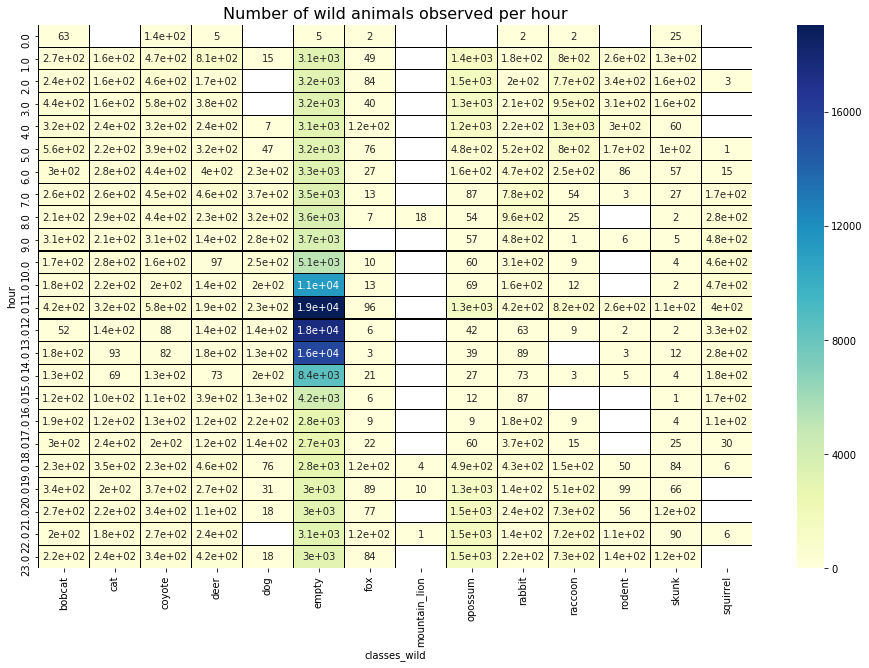

In [29]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'hour'])['seq_id'].count().reset_index())
m = t.pivot(index='hour', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per hour', size=16)
plt.show()

We remove `empty` class, which is observed mostly around noon, to see better the other classes distribution on hours.


## Classes and months

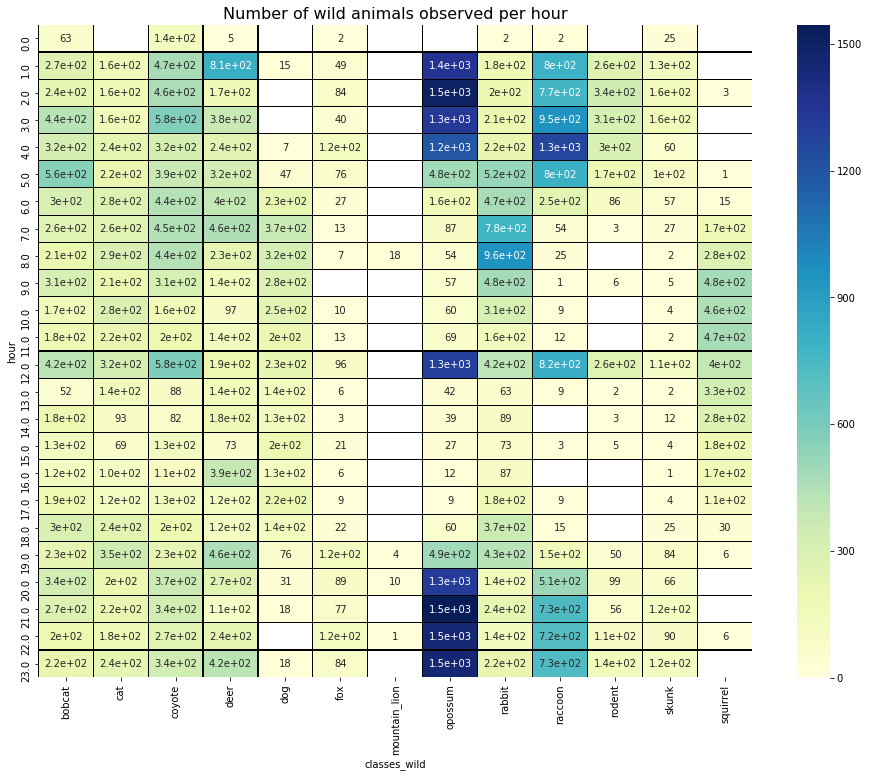

In [30]:
tmp = train_df[train_df['classes_wild'] != 'empty']
fig, ax = plt.subplots(1,1,figsize=(16,12))
t = pd.DataFrame(tmp.groupby(['classes_wild', 'hour'])['seq_id'].count().reset_index())
m = t.pivot(index='hour', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per hour', size=16)
plt.show()

We can observe that majority of racoons and opossums images are captured during night.  

Let's see in what month are each species images mostly captured.

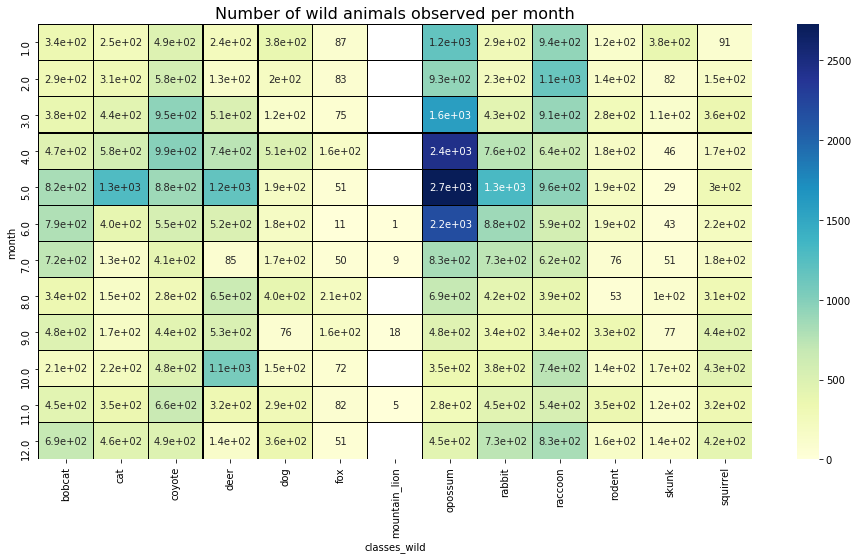

In [31]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
t = pd.DataFrame(tmp.groupby(['classes_wild', 'month'])['seq_id'].count().reset_index())
m = t.pivot(index='month', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per month', size=16)
plt.show()

All these visualizations suffers from one problem: the distribution of majority classes obscures the distribution of minority classes. We will try to create a heatmap for each species. Let's do this showing month and hour for each species, on a separate histogram.


## Classes per hour and month

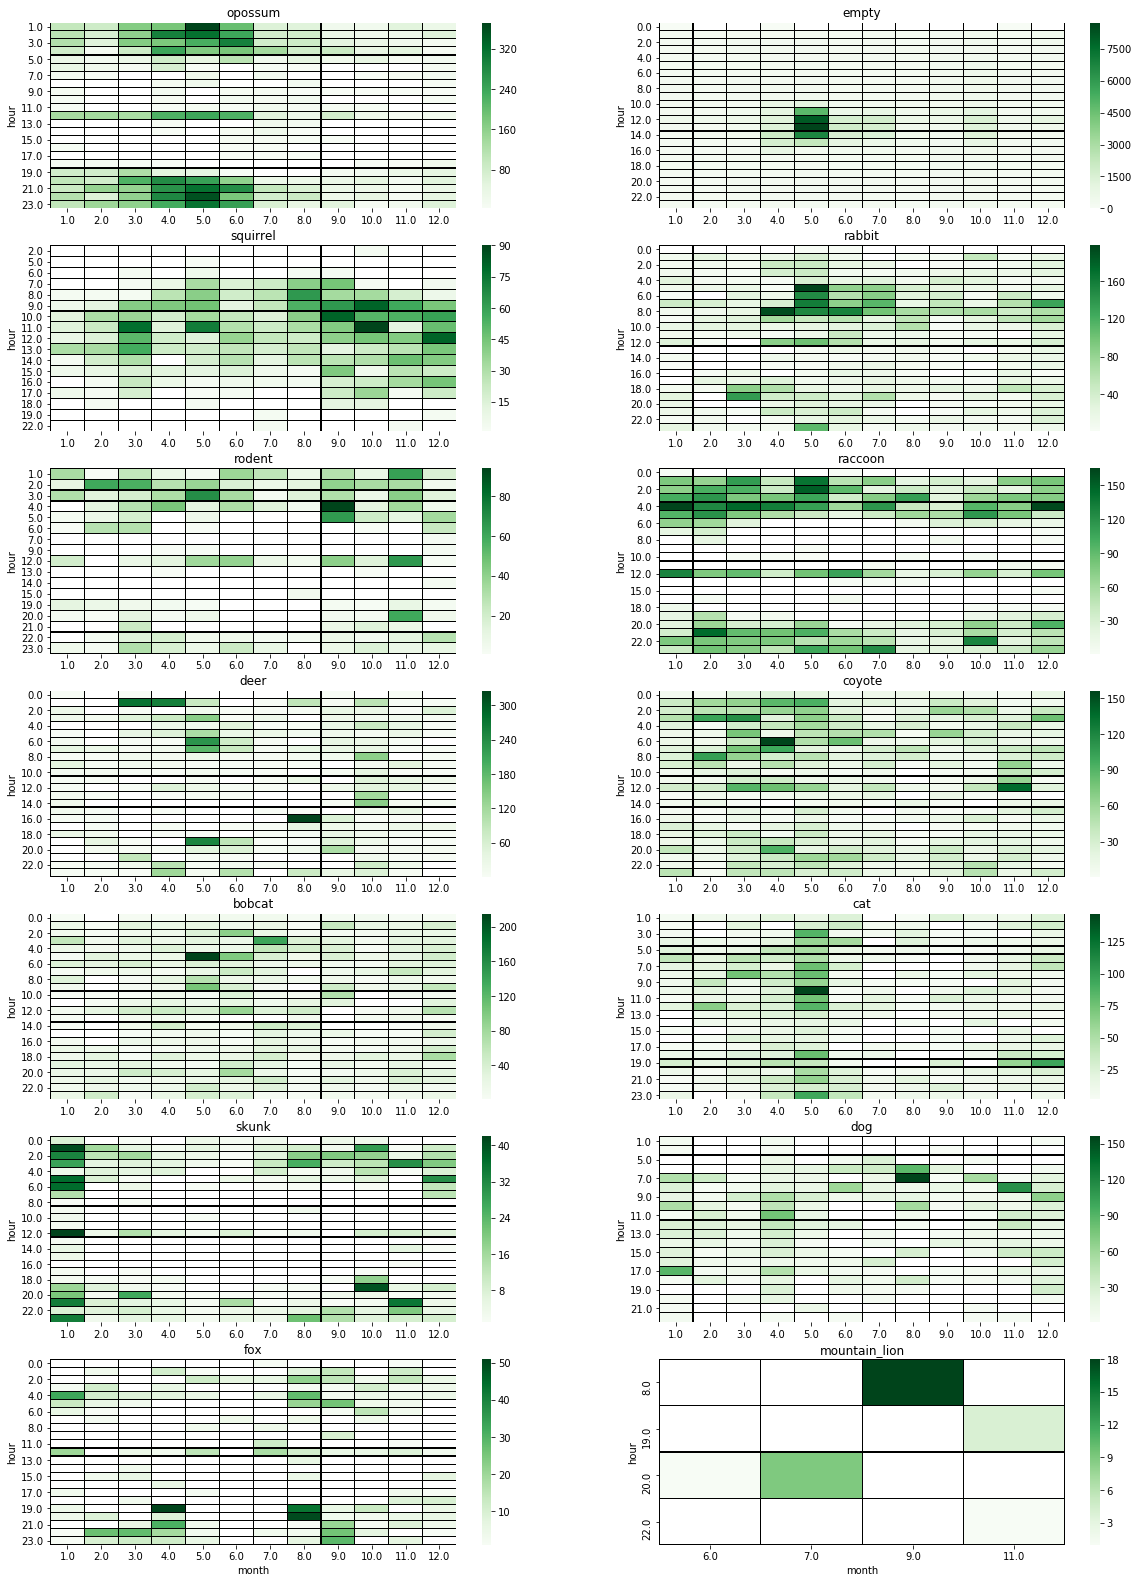

In [32]:
classes = train_df.classes_wild.unique()
fig, ax = plt.subplots(7,2,figsize=(20,28))
i = 0
for class_wild in classes:
    i = i + 1
    plt.subplot(7,2,i)
    tmp = train_df[train_df['classes_wild'] == class_wild]
    t = pd.DataFrame(tmp.groupby(['month', 'hour'])['seq_id'].count().reset_index())
    m = t.pivot(index='hour', columns='month', values='seq_id')
    s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=False, cmap="Greens")
    if(i<13):
        s.set_xlabel('')    
    s.set_title(class_wild, size=12)

plt.show()

## Classes per rights holder and month

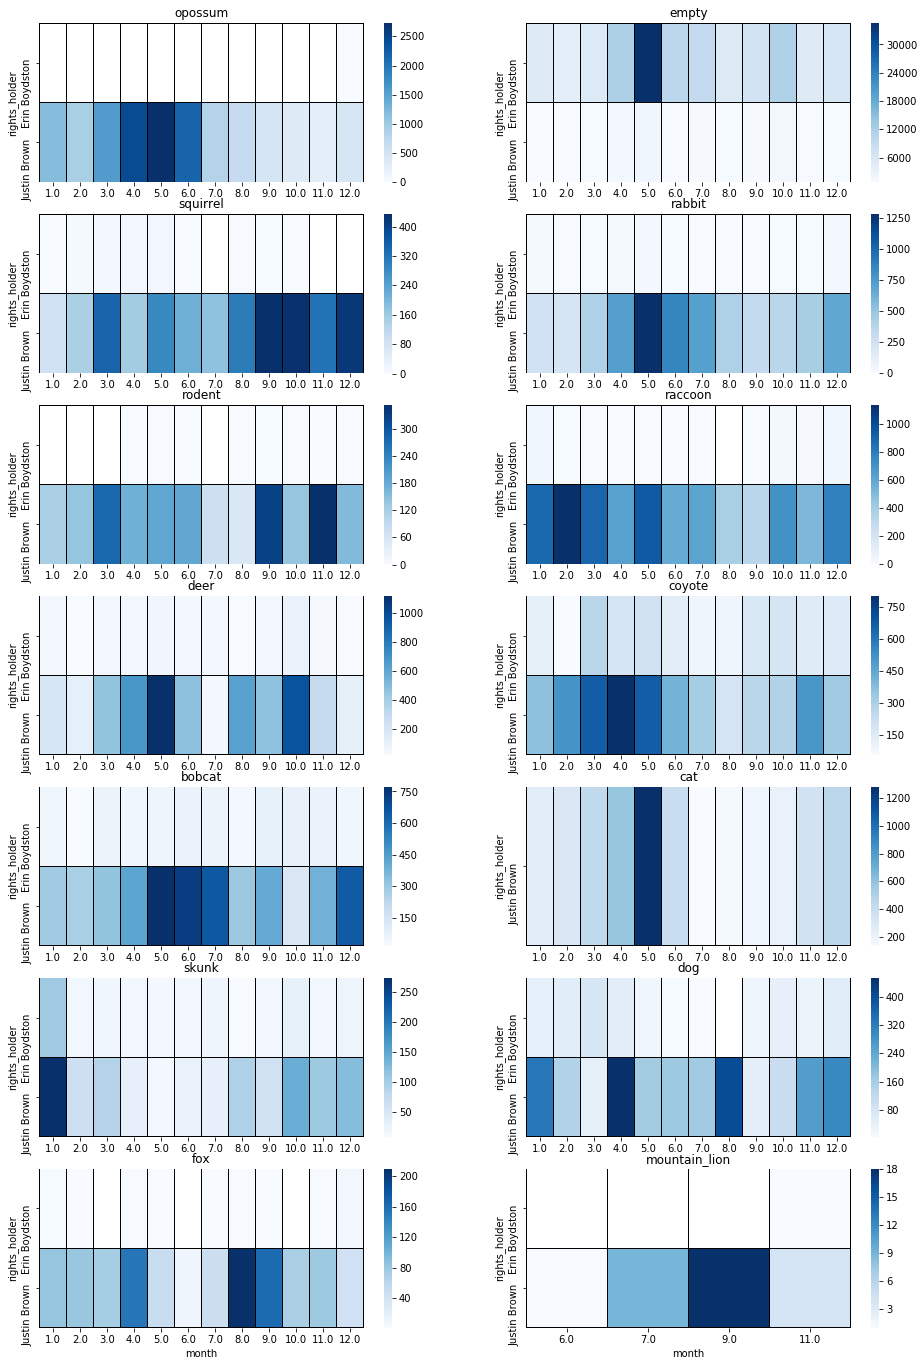

In [33]:
classes = train_df.classes_wild.unique()
fig, ax = plt.subplots(7,2,figsize=(16,24))
i = 0
for class_wild in classes:
    i = i + 1
    plt.subplot(7,2,i)
    tmp = train_df[train_df['classes_wild'] == class_wild]
    t = pd.DataFrame(tmp.groupby(['rights_holder', 'month'])['seq_id'].count().reset_index())
    m = t.pivot(index='rights_holder', columns='month', values='seq_id')
    s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=False, cmap="Blues")
    if(i<13):
        s.set_xlabel('')    
    s.set_title(class_wild, size=12)

plt.show()

## Train images samples   

Let's show a part of the images from train_df set.

In [34]:
def draw_category_images(var,cols=5):
    categories = (train_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(3*cols,3*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = train_df[train_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file_name']
            im = Image.open(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

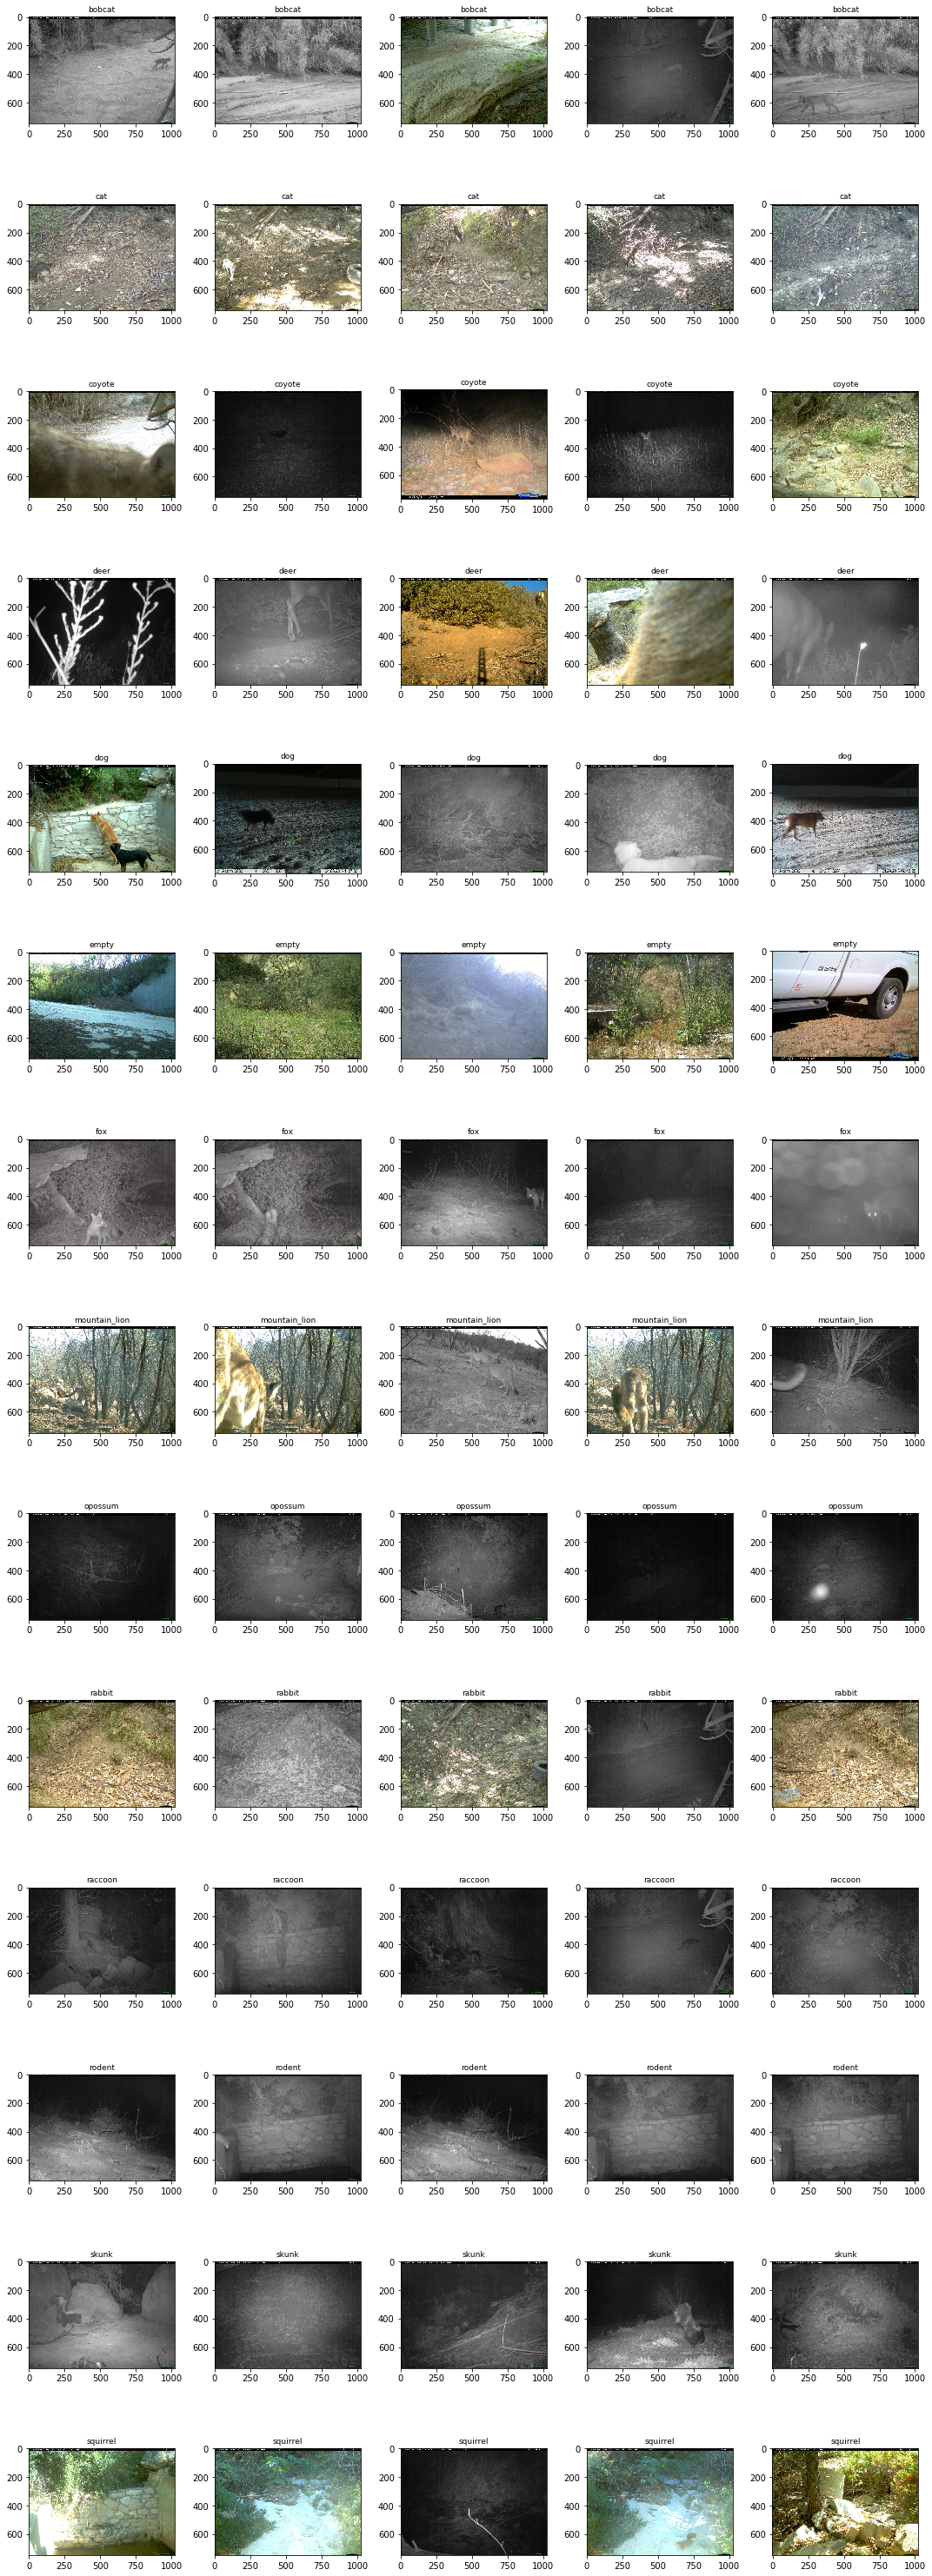

In [35]:
IMAGE_PATH = "../input/train_images/"
draw_category_images('classes_wild')

## Test images samples

Let's also draw few test images samples.

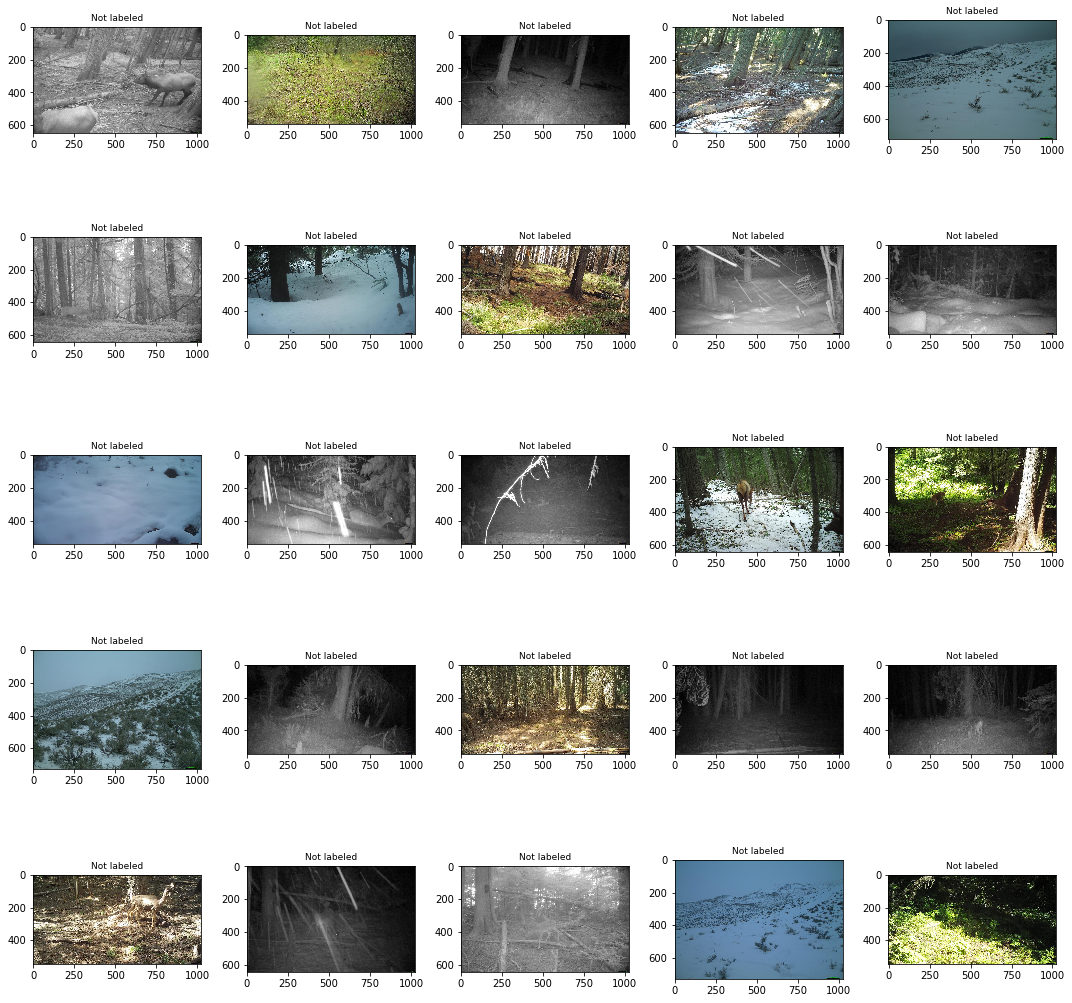

In [36]:
IMAGE_PATH = "../input/test_images/"
f, ax = plt.subplots(nrows=5,ncols=5, figsize=(15,15))

for i in range(5):
    sample = test_df.sample(5)
    for j in range(5):
        file=IMAGE_PATH + sample.iloc[j]['file_name']
        im = Image.open(file)
        ax[i, j].imshow(im, resample=True)
        ax[i, j].set_title('Not labeled', fontsize=9)  
plt.tight_layout()
plt.show()

# <a id='2'>References</a>

[1] https://www.kaggle.com/gpreda/honey-bee-subspecies-classification   
[2] https://www.kaggle.com/gpreda/robots-need-help  
[3] https://www.kaggle.com/artgor/iwildcam-basic-eda  
[4] https://www.kaggle.com/c/iwildcam-2019-fgvc6/  
